# SYDE 556/750: Simulating Neurobiological Systems


Readings: [Stewart et al.](http://compneuro.uwaterloo.ca/publications/stewart2010.html)


## Biological Cognition -- Control

- Lots of contemporary neural models are quite simple
    - Working memory, vision, audition, perceptual decision making, oscillations, etc.

- What happens when our models get more complex?
    - I.e., what happens when the models:
        - Switch modalities?
        - Have a complex environment?
        - Have limited resources?
        - Can't do everything at once?
        


- The brain needs a way to determine how to best use the finite resources it has.
- Think about what happens when:
    - You have two targets to reach to at once (or 3 or 4)
    - You want to get to a goal that requires a series of actions
    - You don't know what the target is, but you know what modality it will be in
    - You don't know what the target will be, but you know where it will be
        


- In all these cases, your brain needs to control the flow of information through it to solve the task.
- Chapter 5 of [How to build a brain](http://compneuro.uwaterloo.ca/publications/eliasmith2013.html) is focussed on relevant neural models.
- That chapter distinguishes two aspects of control:
    1. determining what an appropriate control signal is
    2. applying that signal to change the system
- The first is a kind of decision making called 'action selection'
- The second is more of an implementational question about how to gate information effectively (we've seen several possibilities for this already; e.g. inhibition, multiplication)
- This lecture focusses on the first aspect of control

## Action Selection and the Basal Ganglia

- Actions can be many different things
    - physical movements
    - moving attention
    - changing contents of working memory 
    - recalling items from long-term memory

### Action Selection

- How can we do this?
- Suppose we're a critter that's trying to survive in a harsh environment
- We have a bunch of different possible actions
    - go home
    - move randomly
    - go towards food
    - go away from predators
- Which one do we pick?
    - Ideas?

### Reinforcement Learning
- [Reinforcement learning](http://en.wikipedia.org/wiki/Reinforcement_learning) is a biologically inspired computational approach to machine learning.  It is based on the idea that creatures maximize reward, which seems to be the case (see, e.g., the Rescorla-Wagner model of Pavlov's experiments).
- There have been a lot of [interesting connections](http://www.ncbi.nlm.nih.gov/pubmed/19897789) found between signals in these models and signals in the brain.
- So, let's steal a simple idea from reinforcement learning:
- Each action has a utility $Q$ that depends on the current state $s$
    - $Q(s, a)$ (the action value)
- The best action will then be the action that has the largest $Q$


- Note
    - Lots of different variations on this
    - $V(s)$ (the state value - expected reward given a state & policy)
    - Softmax: $p(a_i) = e^{Q(s, a_i)/T} / \sum_i e^{Q(s, a_i)/T}$ (instead of max)
- In RL research, people come up with learning algorithms for adjusting $Q$ based on rewards
- We won't worry about that for now (see the lecture on learning) and just use the basic idea
    - There's some sort of state $s$
    - For each action $a_i$, compute $Q(s, a_i)$ which is a function that we can define
    - Take the biggest $Q$ and perform that action

### Implementation

- One group of neurons to represent the state $s$
- One group of neurons for each action's utility $Q(s, a_i)$
    - Or one large group of neurons for all the $Q$ values

- What should the output be?
    - We could have $index$, which is the index $i$ of the action with the largest $Q$ value
    - Or we could have something like $[0,0,1,0]$, indicating which action is selected
    - Advantages and disadvantages?
- The second option seems easier if we consider that we have to do action execution next...

### A Simple Example

- State $s$ is 2-dimensional (x,y plane)
- Four actions (A, B, C, D)
- Do action A if $s$ is near [1,0], B if near [-1,0], C if near [0,1], D if near [0,-1]
    - $Q(s, a_A)=s \cdot [1,0]$
    - $Q(s, a_B)=s \cdot [-1,0]$
    - $Q(s, a_C)=s \cdot [0,1]$
    - $Q(s, a_D)=s \cdot [0,-1]$




In [1]:
%pylab inline
import nengo

model = nengo.Network('Selection')

with model:
    stim = nengo.Node(lambda t: [np.sin(t), np.cos(t)])
        
    s = nengo.Ensemble(200, dimensions=2)
    Q_A = nengo.Ensemble(50, dimensions=1)
    Q_B = nengo.Ensemble(50, dimensions=1)
    Q_C = nengo.Ensemble(50, dimensions=1)
    Q_D = nengo.Ensemble(50, dimensions=1)

    nengo.Connection(s, Q_A, transform=[[1,0]])
    nengo.Connection(s, Q_B, transform=[[-1,0]])
    nengo.Connection(s, Q_C, transform=[[0,1]])
    nengo.Connection(s, Q_D, transform=[[0,-1]])
    nengo.Connection(stim, s)
    
    model.config[nengo.Probe].synapse = nengo.Lowpass(0.01)
    qa_p = nengo.Probe(Q_A)
    qb_p = nengo.Probe(Q_B)
    qc_p = nengo.Probe(Q_C)
    qd_p = nengo.Probe(Q_D)
    s_p = nengo.Probe(s)
    
sim = nengo.Simulator(model)
sim.run(3.)

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:02.                                                 


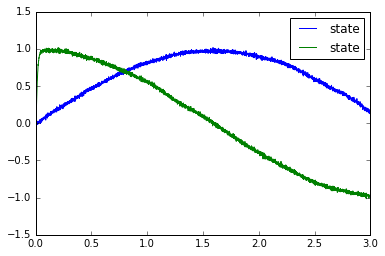

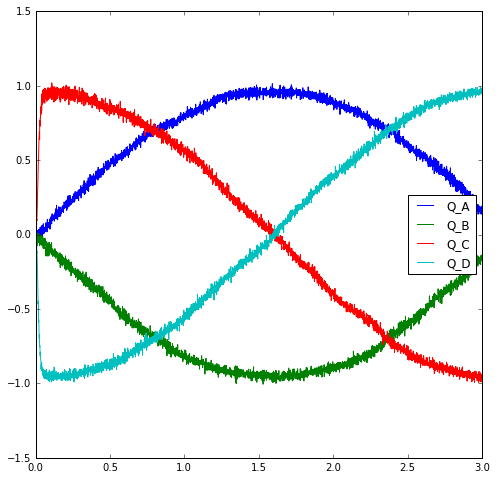

In [2]:
t = sim.trange()

plot(t, sim.data[s_p], label="state")
legend()

figure(figsize=(8,8))
plot(t, sim.data[qa_p], label='Q_A')
plot(t, sim.data[qb_p], label='Q_B')
plot(t, sim.data[qc_p], label='Q_C')
plot(t, sim.data[qd_p], label='Q_D')
legend(loc='best');

- That behavior makes a lot of sense
    - The highest Q happens when an action's 'favorite state' (i.e. when the transform is equal to state) is in s
    
- It's annoying to have all those separate $Q$ neurons
- Perfect opportunity to use the EnsembleArray again (see last lecture)
    - Doesn't change the model at all
    - It just groups things together for you

In [3]:
import nengo

model = nengo.Network('Selection')

with model:
    stim = nengo.Node(lambda t: [np.sin(t), np.cos(t)])
        
    s = nengo.Ensemble(200, dimensions=2)
    Qs = nengo.networks.EnsembleArray(50, n_ensembles=4)
    
    nengo.Connection(s, Qs.input, transform=[[1,0],[-1,0],[0,1],[0,-1]])
    nengo.Connection(stim, s)
    
    model.config[nengo.Probe].synapse = nengo.Lowpass(0.01)
    qs_p = nengo.Probe(Qs.output)
    s_p = nengo.Probe(s)
    
sim = nengo.Simulator(model)
sim.run(3.)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:02.                                                 


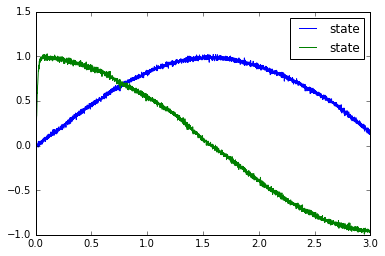

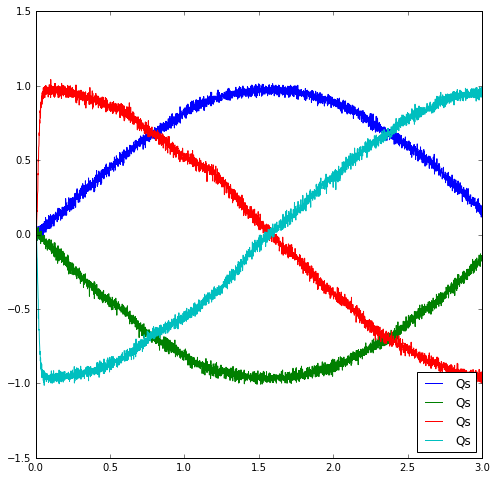

In [4]:
t = sim.trange()

plot(t, sim.data[s_p], label="state")
legend()

figure(figsize=(8,8))
plot(t, sim.data[qs_p], label='Qs')
legend(loc='best');

- Yay, Network Arrays make shorter code!

- Back to the model: How do we implement the $max$ function?
- Well, it's just a function, so let's implement it
    - Need to combine all the $Q$ values into one 4-dimensional ensemble
    - Why?

In [5]:
import nengo

def maximum(x):
    result = [0,0,0,0]
    result[np.argmax(x)] = 1
    return result

model = nengo.Network('Selection')

with model:
    stim = nengo.Node(lambda t: [np.sin(t), np.cos(t)])
        
    s = nengo.Ensemble(200, dimensions=2)
    Qs = nengo.networks.EnsembleArray(50, n_ensembles=4)
    Qall = nengo.Ensemble(400, dimensions=4)
    Action = nengo.Ensemble(200, dimensions=4)
    
    nengo.Connection(s, Qs.input, transform=[[1,0],[-1,0],[0,1],[0,-1]])
    nengo.Connection(Qs.output, Qall)
    nengo.Connection(Qall, Action, function=maximum)
    nengo.Connection(stim, s)
    
    model.config[nengo.Probe].synapse = nengo.Lowpass(0.01)
    qs_p = nengo.Probe(Qs.output)
    action_p = nengo.Probe(Action)
    s_p = nengo.Probe(s)
    
sim = nengo.Simulator(model)
sim.run(3.)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:03.                                                 


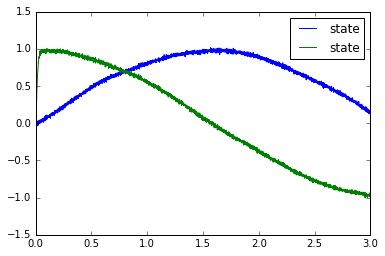

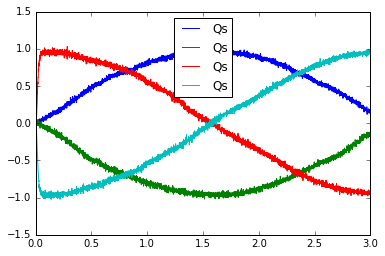

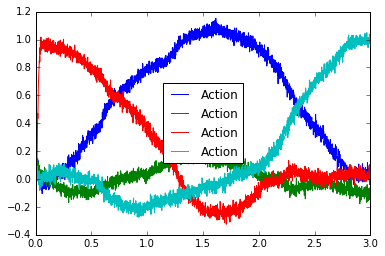

In [6]:
t = sim.trange()

plot(t, sim.data[s_p], label="state")
legend()

figure()
plot(t, sim.data[qs_p], label='Qs')
legend(loc='best')

figure()
plot(t, sim.data[action_p], label='Action')
legend(loc='best');

- Not so great (it looks pretty much the same as the linear case)
- Very nonlinear function, so neurons are not able to approximate it well
- Other options?

### The Standard Neural Network Approach (modified)

- If you give this problem to a standard neural networks person, what would they do?
- They'll say this is exactly what neural networks are great at
    - Implement this with mutual inhibition and self-excitation
- Neural competition
    - 4 "neurons"
    - have excitation from each neuron back to themselves
    - have inhibition from each neuron to all the others
- Now just put in the input and wait for a while and it'll stablize to one option
- Can we do that?
- Sure!  Just replace each "neuron" with a group of neurons, and compute the desired function on those connections
    - note that this is a very general method of converting any non-realistic neural model into a biologically realistic spiking neuron model
    

In [7]:
import nengo

model = nengo.Network('Selection')

with model:
    stim = nengo.Node(lambda t: [.5,.4] if t <1. else [0,0] )
        
    s = nengo.Ensemble(200, dimensions=2)
    Qs = nengo.networks.EnsembleArray(50, n_ensembles=4)
    
    nengo.Connection(s, Qs.input, transform=[[1,0],[-1,0],[0,1],[0,-1]])
    
    e = 0.1
    i = -1

    recur = [[e, i, i, i], [i, e, i, i], [i, i, e, i], [i, i, i, e]]    
    
    nengo.Connection(Qs.output, Qs.input, transform=recur)
    nengo.Connection(stim, s)
    
    model.config[nengo.Probe].synapse = nengo.Lowpass(0.01)
    qs_p = nengo.Probe(Qs.output)
    s_p = nengo.Probe(s)
    
sim = nengo.Simulator(model)
sim.run(1.)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


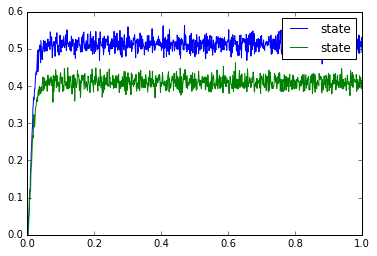

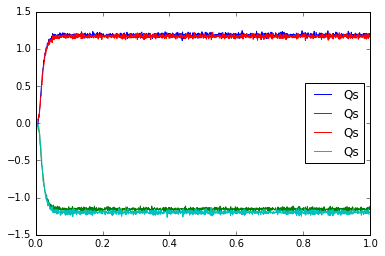

In [8]:
t = sim.trange()

plot(t, sim.data[s_p], label="state")
legend()

figure()
plot(t, sim.data[qs_p], label='Qs')
legend(loc='best');

- Oops, that's not quite right
- Why is it selecting more than one action?

In [9]:
import nengo

model = nengo.Network('Selection')

with model:
    stim = nengo.Node(lambda t: [.5,.4] if t <1. else [0,0] )
        
    s = nengo.Ensemble(200, dimensions=2)
    Qs = nengo.networks.EnsembleArray(50, n_ensembles=4)
    Action = nengo.networks.EnsembleArray(50, n_ensembles=4)
    
    nengo.Connection(s, Qs.input, transform=[[1,0],[-1,0],[0,1],[0,-1]])
    nengo.Connection(Qs.output, Action.input)
    
    e = 0.3
    i = -1

    recur = [[e, i, i, i], [i, e, i, i], [i, i, e, i], [i, i, i, e]]    

    # Let's force the feedback connection to only consider positive values
    def positive(x):
        if x[0]<0: return [0]
        else: return x
    pos = Action.add_output('positive', positive)
    
    nengo.Connection(pos, Action.input, transform=recur)
    nengo.Connection(stim, s)
    
    model.config[nengo.Probe].synapse = nengo.Lowpass(0.01)
    qs_p = nengo.Probe(Qs.output)
    action_p = nengo.Probe(Action.output)
    s_p = nengo.Probe(s)
    
sim = nengo.Simulator(model)
sim.run(1.)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


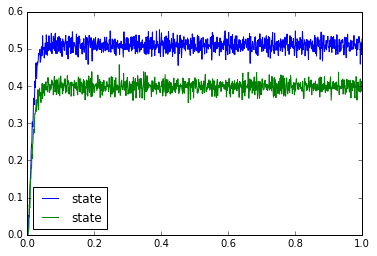

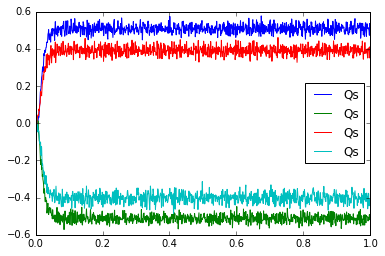

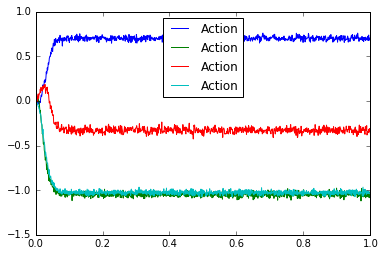

In [10]:
t = sim.trange()

plot(t, sim.data[s_p], label="state")
legend(loc='best')

figure()
plot(t, sim.data[qs_p], label='Qs')
legend(loc='best')

figure()
plot(t, sim.data[action_p], label='Action')
legend(loc='best');

- Now we only influence other Actions when we have a positive value
    - Note: Is there a more neurally efficient way to do this?
- Much better
- Selects one action reliably
- But still gives values smaller than 1.0 for the output a lot
    - Can we fix that?
    - What if we adjust ```e```?

In [11]:
%pylab inline
import nengo

def stimulus(t):
    if t<.3:
        return [.5,.4]
    elif .3<t<.5:
        return [.4,.5]
    else:
        return [0,0] 
    
model = nengo.Network('Selection')

with model:
    stim = nengo.Node(stimulus)
        
    s = nengo.Ensemble(200, dimensions=2)
    Qs = nengo.networks.EnsembleArray(50, n_ensembles=4)
    Action = nengo.networks.EnsembleArray(50, n_ensembles=4)
    
    nengo.Connection(s, Qs.input, transform=[[1,0],[-1,0],[0,1],[0,-1]])
    nengo.Connection(Qs.output, Action.input)
    
    e = .5
    i = -1

    recur = [[e, i, i, i], [i, e, i, i], [i, i, e, i], [i, i, i, e]]    

    # Let's force the feedback connection to only consider positive values
    def positive(x):
        if x[0]<0: return [0]
        else: return x
    pos = Action.add_output('positive', positive)
    
    nengo.Connection(pos, Action.input, transform=recur)
    nengo.Connection(stim, s)
    
    model.config[nengo.Probe].synapse = nengo.Lowpass(0.01)
    qs_p = nengo.Probe(Qs.output)
    action_p = nengo.Probe(Action.output)
    s_p = nengo.Probe(s)
    
sim = nengo.Simulator(model)
sim.run(1.)

'''import nengo_viz
viz = nengo_viz.Viz(model)
viz.slider(stim)
viz.value(s)
viz.value(Qs.output)
viz.value(Action.output)
viz.start()'''

Populating the interactive namespace from numpy and matplotlib
Building finished in 0:00:01.                                                   


`%matplotlib` prevents importing * from pylab and numpy


Simulating finished in 0:00:01.                                                 


'import nengo_viz\nviz = nengo_viz.Viz(model)\nviz.slider(stim)\nviz.value(s)\nviz.value(Qs.output)\nviz.value(Action.output)\nviz.start()'

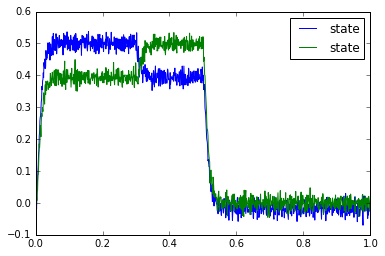

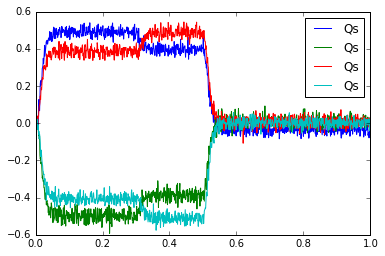

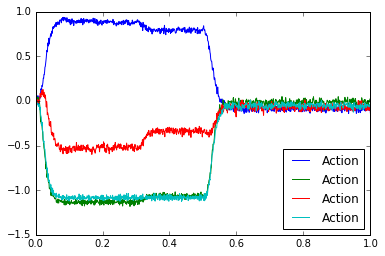

In [12]:
t = sim.trange()

plot(t, sim.data[s_p], label="state")
legend(loc='best')

figure()
plot(t, sim.data[qs_p], label='Qs')
legend(loc='best')

figure()
plot(t, sim.data[action_p], label='Action')
legend(loc='best');

- Hmm, that seems to introduce a new problem
- The self-excitation is so strong that it can't respond to changes in the input
    - Indeed, any method like this is going to have some form of memory effects
    - Notice that what has been implemented is an integrator (sort of)
- Could we do anything to help without increasing ```e``` too much?    

In [14]:
%pylab inline
import nengo

def stimulus(t):
    if t<.3:
        return [.5,.4]
    elif .3<t<.5:
        return [.3,.5]
    else:
        return [0,0] 
    
model = nengo.Network('Selection')

with model:
    stim = nengo.Node(stimulus)
        
    s = nengo.Ensemble(200, dimensions=2)
    Qs = nengo.networks.EnsembleArray(50, n_ensembles=4)
    Action = nengo.networks.EnsembleArray(50, n_ensembles=4)
    
    nengo.Connection(s, Qs.input, transform=[[1,0],[-1,0],[0,1],[0,-1]])
    nengo.Connection(Qs.output, Action.input)
    
    e = 0.2
    i = -1

    recur = [[e, i, i, i], [i, e, i, i], [i, i, e, i], [i, i, i, e]]    

    def positive(x):
        if x[0]<0: return [0]
        else: return x
    pos = Action.add_output('positive', positive)
    
    nengo.Connection(pos, Action.input, transform=recur)
    
    def select(x):
        if x[0]>=0: return [1]
        else: return [0]
    sel = Action.add_output('select', select)
        
    aValues = nengo.networks.EnsembleArray(50, n_ensembles=4)
    
    nengo.Connection(sel, aValues.input)   
    nengo.Connection(stim, s)
    
    model.config[nengo.Probe].synapse = nengo.Lowpass(0.01)
    qs_p = nengo.Probe(Qs.output)
    action_p = nengo.Probe(Action.output)
    aValues_p = nengo.Probe(aValues.output)
    s_p = nengo.Probe(s)
    
sim = nengo.Simulator(model)
sim.run(1.)

'''import nengo_viz
viz = nengo_viz.Viz(model)
viz.slider(stim)
viz.value(s)
viz.value(Qs.output)
viz.value(aValues.output)
viz.start()'''

Populating the interactive namespace from numpy and matplotlib
Building finished in 0:00:01.                                                   


`%matplotlib` prevents importing * from pylab and numpy


Simulating finished in 0:00:02.                                                 


'import nengo_viz\nviz = nengo_viz.Viz(model)\nviz.slider(stim)\nviz.value(s)\nviz.value(Qs.output)\nviz.value(aValues.output)\nviz.start()'

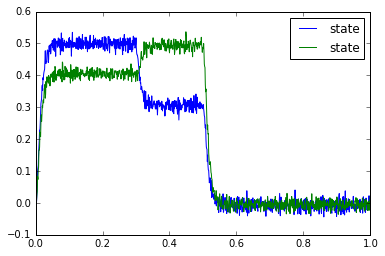

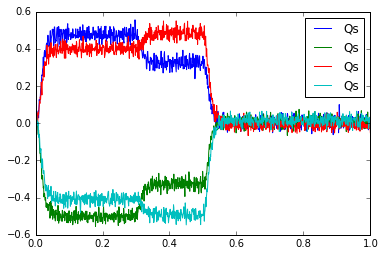

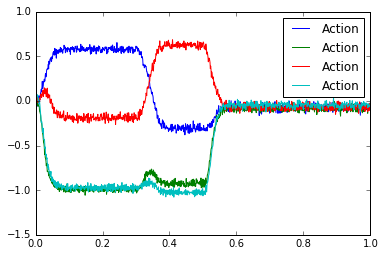

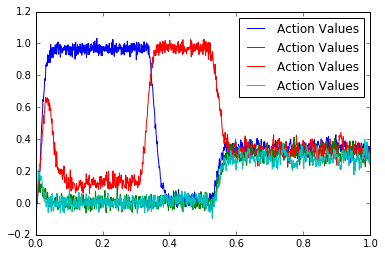

In [15]:
t = sim.trange()

plot(t, sim.data[s_p], label="state")
legend(loc='best')

figure()
plot(t, sim.data[qs_p], label='Qs')
legend(loc='best')

figure()
plot(t, sim.data[action_p], label='Action')
legend(loc='best')

figure()
plot(t, sim.data[aValues_p], label='Action Values')
legend(loc='best');

- Better behaviour
- But there's still situations where there's too much memory (see the visualizer)
- We can reduce this by reducing ```e```

In [31]:
%pylab inline
import nengo

def stimulus(t):
    if t<.3:
        return [.5,.4]
    elif .3<t<.5:
        return [.3,.5]
    else:
        return [0,0] 
    
model = nengo.Network('Selection')

with model:
    stim = nengo.Node(stimulus)
        
    s = nengo.Ensemble(200, dimensions=2)
    Qs = nengo.networks.EnsembleArray(50, n_ensembles=4)
    Action = nengo.networks.EnsembleArray(50, n_ensembles=4)
    
    nengo.Connection(s, Qs.input, transform=[[1,0],[-1,0],[0,1],[0,-1]])
    nengo.Connection(Qs.output, Action.input)
    
    e = 0.1
    i = -1

    recur = [[e, i, i, i], [i, e, i, i], [i, i, e, i], [i, i, i, e]]    

    def positive(x):
        if x[0]<0: return [0]
        else: return x
    pos = Action.add_output('positive', positive)
    
    nengo.Connection(pos, Action.input, transform=recur)
    
    def select(x):
        if x[0]>=0: return [1]
        else: return [0]
    sel = Action.add_output('select', select)
        
    aValues = nengo.networks.EnsembleArray(50, n_ensembles=4)
    
    nengo.Connection(sel, aValues.input)   
    nengo.Connection(stim, s)
    
    model.config[nengo.Probe].synapse = nengo.Lowpass(0.01)
    qs_p = nengo.Probe(Qs.output)
    action_p = nengo.Probe(Action.output)
    aValues_p = nengo.Probe(aValues.output)
    s_p = nengo.Probe(s)
    
#sim = nengo.Simulator(model)
#sim.run(1.)

`%matplotlib` prevents importing * from pylab and numpy


'import nengo_viz\nviz = nengo_viz.Viz(model)\nviz.slider(stim)\nviz.value(s)\nviz.value(Qs.output)\nviz.value(aValues.output)\nviz.start()'

In [32]:
from nengo_gui.ipython import IPythonViz
IPythonViz(model, "configs/bg_simple1.py.cfg")

- Much less memory, but it's still there
- And slower to respond to changes
- Note that this speed is dependent on $e$, $i$, and the time constant of the neurotransmitter used
- Can be hard to find good values


- And this gets harder to balance as the number of actions increases
    - Also hard to balance for a wide range of $Q$ values
        - (Does it work for $Q$=[0.9, 0.9, 0.95, 0.9] and $Q$=[0.2, 0.2, 0.25, 0.2]?)

- But this is still a pretty standard approach
    - Nice and easy to get working for special cases
    - Don't really need the NEF (if you're willing to assume non-realistic non-spiking neurons)
    - (Although really, if you're not looking for biological realism, why not just compute the max function?)
        
- Example: [OReilly, R.C. (2006). Biologically Based Computational Models of High-Level Cognition. Science, 314, 91-94.](http://grey.colorado.edu/mediawiki/sites/CompCogNeuro/images/a/a5/OReilly06.pdf)
    - [Leabra](http://grey.colorado.edu/CompCogNeuro/index.php/CCNBook/Main)
- They tend to use a "kWTA" (k-Winners Take All) approach in their models
    - Set up inhibition so that only $k$ neurons will be active
    - But since that's complex to do, just [do the math instead of doing the inhibition](http://grey.colorado.edu/CompCogNeuro/index.php/CCNBook/Networks#kWTA_Approximation_for_Inhibition)
    - We think that doing it their way means that the dynamics of the model will be wrong (i.e. all the effects we saw above are being ignored).
    
- Any other options?

### Biology

- Let's look at the biology
- Where is this action selection in the brain?
- General consensus: the basal ganglia

<img src="files/lecture_selection/basal_ganglia.jpg" width="500">

- Pretty much all of cortex connects in to this area (via the striatum)
- Output goes to the thalamus, the central routing system of the brain


- Disorders of this area of the brain cause problems controlling actions:
    - Parkinson's disease
        - Neurons in the substantia nigra die off
        - Extremely difficult to trigger actions to start
        - Usually physical actions; as disease progresses and more of the SNc is gone, can get cognitive effects too
    - Huntington's disease
        - Neurons in the striatum die off
        - Actions are triggered inappropriately (disinhibition)
        - Small uncontrollable movements
        - Trouble sequencing cognitive actions too



- Also heavily implicated in reinforcement learning
    - The dopamine levels seem to map onto reward prediction error
    - High levels when get an unexpected reward, low levels when didn't get a reward that was expected
    
<img src="files/lecture_selection/dopamine.png" width="500">



- Connectivity diagram:

<img src="files/lecture_selection/basal_ganglia2.gif" width="500">


- Old terminology:
    - "direct" pathway: cortex -> striatum -> GPi -> thalamus
    - "indirect" pathway: cortex -> striatum -> GPe -> STN -> GPi -> thalamus
- Then they found:
    - "hyperdirect" pathway: cortex -> STN -> GPi -> thalamus
    - and lots of other connections

- Activity in the GPi (output)
    - generally always active
    - neurons stop firing when corresponding action is chosen
    - representing [1, 1, 0, 1] instead of [0, 0, 1, 0]

- Leabra approach
    - Each action has two groups of neurons in the striatum representing $Q(s, a_i)$ and $1-Q(s, a_i)$ ("go" and "no go")
    - Mutual inhibition causes only one of the "go" and one of the "no go" groups to fire
    - GPi neuron get connections from "go" neurons, with value multiplied by -1 (direct pathway)
    - GPi also gets connections from "no go" neurons, but multiplied by -1 (striatum->GPe), then -1 again (GPe->STN), then +1 (STN->GPi)
    - Result in GPi is close to [1, 1, 0, 1] form
- Seems to match onto the biology okay
    - But why the weird double-inverting thing?  Why not skip the GPe and STN entirely?
    - And why split into "go" and "no-go"?  Just the direct pathway on its own would be fine
    - Maybe it's useful for some aspect of the learning...
    - What about all those other connections?
    

### An alternate model of the Basal Ganglia

- Maybe the weird structure of the basal ganglia is an attempt to do action selection without doing mutual inhibition
- Needs to select from a large number of actions
- Needs to do so quickly, and without the memory effects

- [Gurney, Prescott, and Redgrave, 2001](http://neuroinformatics.usc.edu/mediawiki/images/3/37/Gurney_etal_01_A_computational_model_of_action_selection_in_the_basal_ganglia_-_II.pdf)



- Let's start with a very simple version

<img src="files/lecture_selection/gpr1.png">

- Sort of like an "unrolled" version of one step of mutual inhibition
- Note that both A and B have surround inhibition and local excitation that is 'flipped' (in slightly different ways) on the way to the output



- Unfortunately this doesn't easily map onto the basal ganglia because of the diffuse inhibition needed from cortex to what might be the striatum (the first layer).  Instead, we can get similar functionality using something like the following
- Notice the importance of the hyperdirect pathway (from cortex to STN).

<img src="files/lecture_selection/gpr2.png">

- But that's only going to work for very specific $Q$ values. (Here, the winning option is the sum of the losing ones)
- Need to dynamically adjust the amount of +ve and -ve weighting


- Here the GPe is adjusting the weighting by monitoring STN & D2 activity.
- Notice that the GPe gets the same inputs as GPi, but projects back to STN, to 'regulate' the action selection.

<img src="files/lecture_selection/gpr3.png">

- This turns out to work surprisingly well
- But extremely hard to analyze its behaviour
- They showed that it qualitatively matches pretty well



- So what happens if we convert this into realistic spiking neurons?
- Use the same approach where one "neuron" in their model is a pool of neurons in the NEF
- The "neuron model" they use was rectified linear
    - That becomes the function the decoders are computing
- Neurotransmitter time constant are all known
- $Q$ values are between 0 and 1
- Firing rates max out around 50-100Hz
- Encoders are all positive and thresholds are chosen for efficiency

In [64]:
%pylab inline
mm=1
mp=1
me=1
mg=1

#connection strengths from original model
ws=1
wt=1
wm=1
wg=1
wp=0.9
we=0.3

#neuron lower thresholds for various populations
e=0.2  
ep=-0.25
ee=-0.2
eg=-0.2

le=0.2
lg=0.2

D = 10
tau_ampa=0.002
tau_gaba=0.008
N = 50
radius = 1.5

import nengo
from nengo.dists import Uniform

model = nengo.Network('Basal Ganglia', seed=4)

with model:
    stim = nengo.Node([0]*D)

    StrD1 = nengo.networks.EnsembleArray(N, n_ensembles=D, intercepts=Uniform(e,1), 
                                 encoders=Uniform(1,1), radius=radius)
    StrD2 = nengo.networks.EnsembleArray(N, n_ensembles=D, intercepts=Uniform(e,1), 
                                 encoders=Uniform(1,1), radius=radius)
    STN = nengo.networks.EnsembleArray(N, n_ensembles=D, intercepts=Uniform(ep,1), 
                                 encoders=Uniform(1,1), radius=radius)
    GPi = nengo.networks.EnsembleArray(N, n_ensembles=D, intercepts=Uniform(eg,1), 
                                 encoders=Uniform(1,1), radius=radius)
    GPe = nengo.networks.EnsembleArray(N, n_ensembles=D, intercepts=Uniform(ee,1), 
                                 encoders=Uniform(1,1), radius=radius)

    nengo.Connection(stim, StrD1.input, transform=ws*(1+lg), synapse=tau_ampa)
    nengo.Connection(stim, StrD2.input, transform=ws*(1-le), synapse=tau_ampa)
    nengo.Connection(stim, STN.input, transform=wt, synapse=tau_ampa)
    
    def func_str(x): #relu-like function
        if x[0]<e: return 0
        return mm*(x[0]-e)
    strd1_out = StrD1.add_output('func_str', func_str)
    strd2_out = StrD2.add_output('func_str', func_str)
    
    nengo.Connection(strd1_out, GPi.input, transform=-wm, synapse=tau_gaba)
    nengo.Connection(strd2_out, GPe.input, transform=-wm, synapse=tau_gaba)
    
    def func_stn(x):
        if x[0]<ep: return 0
        return mp*(x[0]-ep)
    stn_out = STN.add_output('func_stn', func_stn)
    
    tr=[[wp]*D for i in range(D)]    
    nengo.Connection(stn_out, GPi.input, transform=tr, synapse=tau_ampa)
    nengo.Connection(stn_out, GPe.input, transform=tr, synapse=tau_ampa)

    def func_gpe(x):
        if x[0]<ee: return 0
        return me*(x[0]-ee)
    gpe_out = GPe.add_output('func_gpe', func_gpe)
    
    nengo.Connection(gpe_out, GPi.input, transform=-we, synapse=tau_gaba)
    nengo.Connection(gpe_out, STN.input, transform=-wg, synapse=tau_gaba)

    Action = nengo.networks.EnsembleArray(N, n_ensembles=D, intercepts=Uniform(0.2,1), 
                             encoders=Uniform(1,1))
    bias = nengo.Node([1]*D)
    nengo.Connection(bias, Action.input)
    nengo.Connection(Action.output, Action.input, transform=(np.eye(D)-1), synapse=tau_gaba)
    
    def func_gpi(x):
        if x[0]<eg: return 0
        return mg*(x[0]-eg)
    gpi_out = GPi.add_output('func_gpi', func_gpi)
    
    nengo.Connection(gpi_out, Action.input, transform=-3, synapse=tau_gaba)

`%matplotlib` prevents importing * from pylab and numpy


In [65]:
from nengo_gui.ipython import IPythonViz
IPythonViz(model, "configs/bg_good2.py.cfg")

- Notice that we are also flipping the output from [1, 1, 0, 1] to [0, 0, 1, 0]
    - Mostly for our convenience, but we can also add some mutual inhibition there

- Works pretty well
- Scales up to many actions
- Selects quickly


- Gets behavioural match to empirical data, including timing predictions (!)
    - Also shows interesting oscillations not seen in the original GPR model
    - But these are seen in the real basal ganglia

<img src="files/lecture_selection/gpr-latency.png">

- [Dynamic Behaviour of a Spiking Model of Action Selection in the Basal Ganglia](http://compneuro.uwaterloo.ca/files/publications/stewart.2010.pdf)

- Let's make sure this works with our original system
- To make it easy to use the basal ganglia, there is a special network constructor
    - Since this is a major component of the SPA, it's also in that module

In [66]:
%pylab inline
import nengo
from nengo.dists import Uniform

model = nengo.Network(label='Selection')

D=4

with model:
    stim = nengo.Node([0,0])
        
    s = nengo.Ensemble(200, dimensions=2)
    Qs = nengo.networks.EnsembleArray(50, n_ensembles=D)

    nengo.Connection(stim, s)
    nengo.Connection(s, Qs.input, transform=[[1,0],[-1,0],[0,1],[0,-1]])
    
    Action = nengo.networks.EnsembleArray(50, n_ensembles=D, intercepts=Uniform(0.2,1), 
                             encoders=Uniform(1,1))
    bias = nengo.Node([1]*D)
    nengo.Connection(bias, Action.input)
    nengo.Connection(Action.output, Action.input, transform=(np.eye(D)-1), synapse=0.008)    

    basal_ganglia = nengo.networks.BasalGanglia(dimensions=D)    
    
    nengo.Connection(Qs.output, basal_ganglia.input, synapse=None)
    nengo.Connection(basal_ganglia.output, Action.input)


`%matplotlib` prevents importing * from pylab and numpy


In [67]:
from nengo_gui.ipython import IPythonViz
IPythonViz(model, "configs/bg_good1.py.cfg")

- This system seems to work well
- Still not perfect
- Matches biology nicely, because of how we implemented it




- Some more details on the basal ganglia implementation
    - all those parameters come from here

<img src="files/lecture_selection/gpr-diagram.png" width="500">



- In the original model, each action has a single "neuron" in each area that responds like this:

$$
y = \begin{cases}
    0 &\mbox{if } x < \epsilon \\ 
    m(x- \epsilon) &\mbox{otherwise} 
    \end{cases}
$$

- These need to get turned into groups of neurons
    - What is the best way to do this?

<img src="files/lecture_selection/gpr-tuning.png">

- encoders are all +1
- intercepts are chosen to be $> \epsilon$

## Action Execution

- Now that we can select an action, how do we perform it?
- Depends on what the action is
- Let's start with simple actions
    - Move in a given direction
    - Remember a specific vector
    - Send a particular value as input into a particular cognitive system

    

- Example:
    - State $s$ is 2-dimensional
    - Four actions (A, B, C, D)
    - Do action A if $s$ is near [1,0], B if near [-1,0], C if near [0,1], D if near [0,-1]
        - $Q(s, a_A)=s \cdot [1,0]$
        - $Q(s, a_B)=s \cdot [-1,0]$
        - $Q(s, a_C)=s \cdot [0,1]$
        - $Q(s, a_D)=s \cdot [0,-1]$
    - To do Action A, set $m=[1,0]$
    - To do Action B, set $m=[-1,0]$
    - To do Action C, set $m=[0,1]$
    - To do Action D, set $m=[0,-1]$

In [3]:
%pylab inline
import nengo
from nengo.dists import Uniform

model = nengo.Network(label='Selection')

D=4

with model:
    stim = nengo.Node([0,0])
        
    s = nengo.Ensemble(200, dimensions=2)
    Qs = nengo.networks.EnsembleArray(50, n_ensembles=4)

    nengo.Connection(stim, s)
    nengo.Connection(s, Qs.input, transform=[[1,0],[-1,0],[0,1],[0,-1]])
    
    Action = nengo.networks.EnsembleArray(50, n_ensembles=D, intercepts=Uniform(0.2,1), 
                             encoders=Uniform(1,1))
    bias = nengo.Node([1]*D)
    nengo.Connection(bias, Action.input)
    nengo.Connection(Action.output, Action.input, transform=(np.eye(D)-1), synapse=0.008)    

    basal_ganglia = nengo.networks.BasalGanglia(dimensions=D)    
    
    nengo.Connection(Qs.output, basal_ganglia.input, synapse=None)
    nengo.Connection(basal_ganglia.output, Action.input)
    
    motor = nengo.Ensemble(100, dimensions=2)
    nengo.Connection(Action.output[0], motor, transform=[[1],[0]])
    nengo.Connection(Action.output[1], motor, transform=[[-1],[0]])
    nengo.Connection(Action.output[2], motor, transform=[[0],[1]])
    nengo.Connection(Action.output[3], motor, transform=[[0],[-1]])


In [4]:
from nengo_gui.ipython import IPythonViz
IPythonViz(model, "configs/bg_good3.py.cfg")

- What about more complex actions?
- Consider a simple creature that goes where it's told, or runs away if it's scared
    - Action 1: set $m$ to the direction it's told to do
    - Action 2: set $m$ to the direction we started from
- Need to pass information from one group of neurons to another
    - But only do this when the action is chosen
    - How?
- Well, let's use a function
    - $m = a*d$
    - where $a$ is the action selection (0 for not selected, 1 for selected)
- Let's try that with the creature

In [17]:
%pylab inline
import nengo
from nengo.dists import Uniform

model = nengo.Network('Creature')

with model:
    stim = nengo.Node([0,0], label='stim')
    command = nengo.Ensemble(100, dimensions=2, label='command')
    motor = nengo.Ensemble(100, dimensions=2, label='motor')
    position = nengo.Ensemble(1000, dimensions=2, label='position')
    scared_direction = nengo.Ensemble(100, dimensions=2, label='scared direction')

    def negative(x):
        return -x[0], -x[1]

    nengo.Connection(position, scared_direction, function=negative)
    nengo.Connection(position, position, synapse=.05)
    
    def rescale(x):
        return x[0]*0.1, x[1]*0.1
    nengo.Connection(motor, position, function=rescale)
    nengo.Connection(stim, command)
    
    D=4
    Q_input = nengo.Node([0,0,0,0], label='select')
    Qs = nengo.networks.EnsembleArray(50, n_ensembles=4)
    nengo.Connection(Q_input, Qs.input)
    Action = nengo.networks.EnsembleArray(50, n_ensembles=D, intercepts=Uniform(0.2,1), 
                             encoders=Uniform(1,1))
    bias = nengo.Node([1]*D)
    nengo.Connection(bias, Action.input)
    nengo.Connection(Action.output, Action.input, transform=(np.eye(D)-1), synapse=0.008)    

    basal_ganglia = nengo.networks.BasalGanglia(dimensions=D)    
    
    nengo.Connection(Qs.output, basal_ganglia.input, synapse=None)
    nengo.Connection(basal_ganglia.output, Action.input)

    do_command = nengo.Ensemble(300, dimensions=3, label='do command')

    nengo.Connection(command, do_command[0:2])
    nengo.Connection(Action.output[0], do_command[2])
                     
    def apply_command(x):
        return x[2]*x[0], x[2]*x[1]
    nengo.Connection(do_command, motor, function=apply_command)
    
    do_scared = nengo.Ensemble(300, dimensions=3, label='do scared')

    nengo.Connection(scared_direction, do_scared[0:2])
    nengo.Connection(Action.output[1], do_scared[2])
    nengo.Connection(do_scared, motor, function=apply_command)
 

`%matplotlib` prevents importing * from pylab and numpy


In [19]:
from nengo_gui.ipython import IPythonViz
IPythonViz(model, "configs/bg_creature.py.cfg")
#first dimensions activates do_command, i.e. go in the indicated direciton
#second dimension activates do_scared, i.e. return 'home' (0,0)
#creature tracks the position it goes to (by integrating)
#creature inverts direction to position via scared direction/do_scared and puts that into motor

- There's also another way to do this
- A special case for forcing a function to go to zero when a particular group of neurons is active


In [14]:
%pylab inline
import nengo
from nengo.dists import Uniform

model = nengo.Network('Creature')

with model:
    stim = nengo.Node([0,0], label='stim')
    command = nengo.Ensemble(100, dimensions=2, label='command')
    motor = nengo.Ensemble(100, dimensions=2, label='motor')
    position = nengo.Ensemble(1000, dimensions=2, label='position')
    scared_direction = nengo.Ensemble(100, dimensions=2, label='scared direction')

    def negative(x):
        return -x[0], -x[1]

    nengo.Connection(position, scared_direction, function=negative)
    nengo.Connection(position, position, synapse=.05)
    
    def rescale(x):
        return x[0]*0.1, x[1]*0.1
    nengo.Connection(motor, position, function=rescale)
    nengo.Connection(stim, command)
    
    D=4
    Q_input = nengo.Node([0,0,0,0], label='select')
    Qs = nengo.networks.EnsembleArray(50, n_ensembles=4)
    nengo.Connection(Q_input, Qs.input)
    Action = nengo.networks.EnsembleArray(50, n_ensembles=D, intercepts=Uniform(0.2,1), 
                             encoders=Uniform(1,1))
    bias = nengo.Node([1]*D)
    nengo.Connection(bias, Action.input)
    nengo.Connection(Action.output, Action.input, transform=(np.eye(D)-1), synapse=0.008)    

    basal_ganglia = nengo.networks.BasalGanglia(dimensions=D)    
    
    nengo.Connection(Qs.output, basal_ganglia.input, synapse=None)
    nengo.Connection(basal_ganglia.output, Action.input)

    do_command = nengo.Ensemble(300, dimensions=2, label='do command')
    nengo.Connection(command, do_command)
    nengo.Connection(Action.output[1], do_command.neurons, transform=-np.ones([300,1]))
    nengo.Connection(do_command, motor)
    
    do_scared = nengo.Ensemble(300, dimensions=2, label='do scared')
    nengo.Connection(scared_direction, do_scared)
    nengo.Connection(Action.output[0], do_scared.neurons, transform=-np.ones([300,1]))
    nengo.Connection(do_scared, motor)    

`%matplotlib` prevents importing * from pylab and numpy


In [16]:
from nengo_gui.ipython import IPythonViz
IPythonViz(model, "configs/bg_creature2.py.cfg")

- This is a situation where it makes sense to ignore the NEF!
    - All we want to do is shut down the neural activity
    - So just do a very inhibitory connection

## The Cortex-Basal Ganglia-Thalamus loop

- We now have everything we need for a model of one of the primary structures in the mammalian brain
    - Basal ganglia: action selection
    - Thalamus: action execution
    - Cortex: everything else
    
<img src="lecture_selection/ctx-bg-thal.png" width="800">    
    


- We build systems in cortex that give some input-output functionality
    - We set up the basal ganglia and thalamus to make use of that functionality appropriately
    
- Example
    - Cortex stores some state (integrator)
    - Add some state transition rules
        - If in state A, go to state B
        - If in state B, go to state C
        - If in state C, go to state D
        - ...
    - For now, let's just have states A, B, C, D, etc be some randomly chosen vectors        
    - $Q(s, a_i) = s \cdot a_i$
    - The effect of each action is to input the corresponding vector into the integrator
    - This is the basic loop of the SPA, so we can use that module

In [26]:
%pylab inline
import nengo
from nengo import spa

D = 16

def start(t):
    if t < 0.05:
        return 'A'
    else:
        return '0'
    
model = spa.SPA(label='Sequence_Module', seed=5)

with model:
    model.cortex = spa.Buffer(dimensions=D, label='cortex')
    model.input = spa.Input(cortex=start, label='input')    

    actions = spa.Actions(
        'dot(cortex, A) --> cortex = B',
        'dot(cortex, B) --> cortex = C',
        'dot(cortex, C) --> cortex = D',
        'dot(cortex, D) --> cortex = E',
        'dot(cortex, E) --> cortex = A'
    )
    model.bg = spa.BasalGanglia(actions=actions)
    model.thal = spa.Thalamus(model.bg)

    cortex = nengo.Probe(model.cortex.state.output, synapse=0.01)
    actions = nengo.Probe(model.thal.actions.output, synapse=0.01)
    utility = nengo.Probe(model.bg.input, synapse=0.01)
    
sim = nengo.Simulator(model)
sim.run(0.5)


In [27]:
from nengo_gui.ipython import IPythonViz
IPythonViz(model, "configs/bg_alphabet.py.cfg")

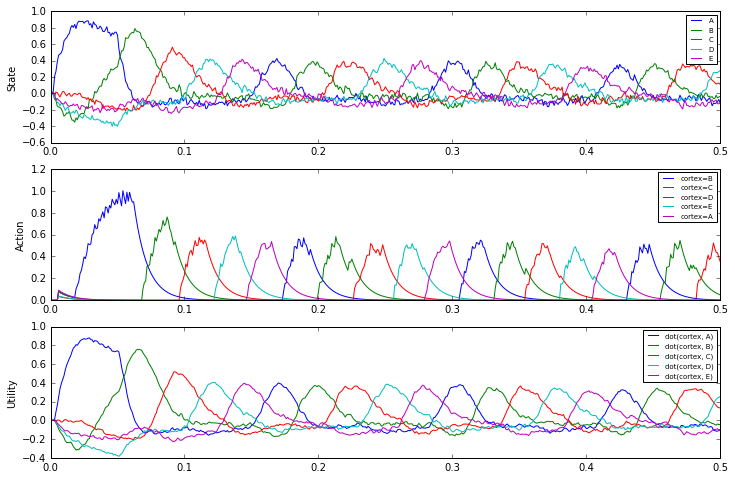

In [28]:
fig = figure(figsize=(12,8))
p1 = fig.add_subplot(3,1,1)

p1.plot(sim.trange(), model.similarity(sim.data, cortex))
p1.legend(model.get_output_vocab('cortex').keys, fontsize='x-small')
p1.set_ylabel('State')

p2 = fig.add_subplot(3,1,2)
p2.plot(sim.trange(), sim.data[actions])
p2_legend_txt = [a.effect for a in model.bg.actions.actions]
p2.legend(p2_legend_txt, fontsize='x-small')
p2.set_ylabel('Action')

p3 = fig.add_subplot(3,1,3)
p3.plot(sim.trange(), sim.data[utility])
p3_legend_txt = [a.condition for a in model.bg.actions.actions]
p3.legend(p3_legend_txt, fontsize='x-small')
p3.set_ylabel('Utility')

fig.subplots_adjust(hspace=0.2)

### Behavioural Evidence

- Is there any evidence that this is the way it works in brains?
     - Consistent with anatomy/connectivity
- What about behavioural evidence?

- A few sources of support
- Timing data
    - How long does it take to do an action?
    - There are lots of existing computational (non-neural) cognitive models that have something like this action selection loop
    - Usually all-symbolic
        - A set of IF-THEN rules
    - e.g. [ACT-R](http://act-r.psy.cmu.edu/)
        - Used to model mental arithmetic, driving a car, using a GUI, air-traffic control, staffing a battleship, etc etc
    - Best fit across all these situations is to set the loop time to 50ms


- How long does this model take?
    - Notice that all the timing is based on neural properties, not the algorithm
    - Dominated by the longer neurotransmitter time constants in the basal ganglia

<img src="files/lecture_selection/timing-simple.png">
<center>Simple actions</center>
<img src="files/lecture_selection/timing-complex.png">
<center>Complex actions (routing)</center>

- This is in the right ballpark


- But what about this distinction between the two types of actions?
    - Not a distinction made in the literature
    - But once we start looking for it, there is evidence
    - [Resolves an outstanding weirdness where some actions seem to take twice as long as others](http://www.cogsci.northwestern.edu/cogsci2004/papers/paper425.pdf)
    - Starting to be lots of citations for 40ms for simple tasks 
        - [Task artifacts and strategic adaptation in the change signal task](http://act-r.psy.cmu.edu/wordpress/wp-content/uploads/2014/01/2013-moore_gunzelmann-CSR.pdf)
- This is a nice example of the usefulness of making neural models!
    - This distinction wasn't obvious from computational implementations

### More complex tasks

- Lots of complex tasks can be modelled this way
    - Some basic cognitive components (cortex)
    - action selection system (basal ganglia and thalamus)
- The tricky part is figuring out the actions


- Example: the Tower of Hanoi task
    - 3 pegs
    - N disks of different sizes on the pegs
    - move from one configuration to another
    - can only move one disk at a time
    - no larger disk can be on a smaller disk
    
<img src="files/lecture_selection/hanoi.png">

- can we build rules to do this?

In [7]:
from IPython.display import YouTubeVideo
YouTubeVideo('sUvHCs5y0o8', width=640, height=390, loop=1, autoplay=0)

- How do people do this task?
    - Studied extensively by cognitive scientists
    - Simon (1975):
        1. Find the largest disk not in its goal position and make the goal to get it in that position.  This is the initial “goal move” for purposes of the next two steps. If all disks are in their goal positions, the problem is solved
        2. If there are any disks blocking the goal move, find the largest blocking disk (either on top of the disk to be moved or at the destination peg) and make the new goal move to move this blocking disk to the other peg (i.e., the peg that is neither the source nor destination of this disk). The previous goal move is stored as the parent goal of the new goal move. Repeat this step with the new goal move.
        3. If there are no disks blocking the goal move perform the goal move and (a) If the goal move had a parent goal retrieve that parent goal, make it the goal move, and go back to step 2. (b) If the goal had no parent goal, go back to step 1.

- What do the actions look like?
- State:
    - `goal`: what disk am I trying to move (D0, D1, D2)
    - `focus`: what disk am I looking at (D0, D1, D2)
    - `goal_peg`: where is the disk I am trying to move (A, B, C)
    - `focus_peg`: where is the disk I am looking at (A, B, C)
    - `target_peg`: where am I trying to move a disk to (A, B, C)
    - `goal_final`: what is the overall final desired location of the disk I'm trying to move (A, B, C)

- Note: we're not yet modelling all the sensory and memory stuff (e.g. loading) here, so we manually set things like `goal_final`.



- Action effects: when an action is selected, it could do the following
    - set `focus`
    - set `goal`
    - set `goal_peg`
    - actually try to move a disk to a given location by setting `move` and `move_peg`
        - Note: we're also not modelling the full motor system, so we fake this too, i.e. the peg moves when we want it to
        
- Is this sufficient to implement the algorithm described above?

- What do the action rules look like?
    - if `focus`=NONE then `focus`=D2, `goal`=D2, `goal_peg`=`goal_final`
        - the antecedent is implemented as $Q$=`focus` $\cdot$ NONE 
    - if `focus`=D2 and `goal`=D2 and `goal_peg`!=`target_peg` then `focus`=D1
        - the antecedent is implemented as $Q$=`focus` $\cdot$ D2 + `goal` $\cdot$ D2 - `goal_peg` $\cdot$ `target_peg`
    - if `focus`=D2 and `goal`=D2 and `goal_peg`==`target_peg` then `focus`=D1, `goal`=D1, `goal_peg`=`goal_final`
    - if `focus`=D1 and `goal`=D1 and `goal_peg`!=`target_peg` then `focus`=D0
    - if `focus`=D1 and `goal`=D1 and `goal_peg`==`target_peg` then `focus`=D0, `goal`=D0, `goal_peg`=`goal_final`
    - if `focus`=D0 and `goal_peg`==`target_peg` then `focus`=NONE
    - if `focus`=D0 and `goal`=D0 and `goal_peg`!=`target_peg` then `focus`=NONE, `move`=D0, `move_peg`=`target_peg`
    - if `focus`!=`goal` and `focus_peg`==`goal_peg` and `target_peg!=focus_peg` then `goal`=`focus`, `goal_peg`=A+B+C-`target_peg`-`focus_peg`
        - trying to move something, but smaller disk is on top of this one
    - if `focus`!=`goal` and `focus_peg`!=`goal_peg` and `target_peg==focus_peg` then `goal`=`focus`, `goal_peg`=A+B+C-`target_peg`-`goal_peg`
        - trying to move something, but smaller disk is on top of target peg
    - if `focus`=D0 and `goal`!=D0 and `target_peg`!=`focus_peg` and `target_peg`!=`goal_peg` and `focus_peg`!=`goal_peg` then `move`=`goal`, `move_peg`=`target_peg`
        - move the disk, since there's nothing in the way
    - if `focus`=D1 and `goal`!=D1 and `target_peg`!=`focus_peg` and `target_peg`!=`goal_peg` and `focus_peg`!=`goal_peg` then `focus`=D0
        - check the next disk
        
        
        
    
    

- Sufficient to solve any version of the problem
- Is it what people do?
- How can we tell?


- Do science
    - What predictions does the theory make
    - Errors?
    - Reaction times?
    - Neural activity?
    - fMRI?

- Timing:

<img src="files/lecture_selection/hanoi-timing.png">

- The model doesn't quite capture some aspects of the human data
- Much longer pauses in some situations than there should be
- At those stages, it is recomputing plans that it has made previously
    - People probably remember those, and don't restart from scratch
    - Need to add that into the model
- [Neural Cognitive Modelling: A Biologically Constrained Spiking Neuron Model of the Tower of Hanoi Task](http://compneuro.uwaterloo.ca/files/publications/stewart.2011a.pdf)